Check GPU RAM for the current Colab Runtime

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=01a7dd89c764a14c08819cea685cba788d2f35eadc530f25dff10d4228095dcd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
path = '/content/drive/My Drive/Covid-19'

**Import the Relvant Libraries**

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import AveragePooling2D, SeparableConv2D, Dropout, Flatten, Dense, Input, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

In [0]:
# Helper Functions
def show_image(img):
    '''
    Quick display of image in grayscale 
    '''
    plt.imshow(img, cmap = 'gray')
    plt.title('Example X-Ray scan')
    plt.grid(False)
    plt.axis('off')
    plt.show()

def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''
    print(classification_report(labels, predictions,
	target_names=lb.classes_))

    cm = confusion_matrix(labels, predictions)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print("accuracy: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    print()
    print('Correct Healthy Patient Detection (True Negatives): ', cm[0][0])
    print('Incorrect Covid-19 Detection (False Positives): ', cm[0][1])
    print('Incorrect Healthy Patient Detection (False Negatives): ', cm[1][0])
    print('Correct Covid-19 Detection (True Positives): ', cm[1][1])
    print('Total Patietns with Covid-19: ', np.sum(cm[1]))

    print()
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [6]:
df = pd.read_csv(f'{path}/metadata.csv')
df.head() # Show samples from Covid-19 dataset 

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [7]:
df[['finding','view','modality','location']]

,finding,view,modality,location
0,COVID-19,PA,X-ray,NaN
1,COVID-19,PA,X-ray,NaN
2,COVID-19,PA,X-ray,NaN
3,COVID-19,PA,X-ray,NaN
4,COVID-19,PA,X-ray,"Changhua Christian Hospital, Changhua City, Ta..."
...,...,...,...,...
141,COVID-19,AP Supine,X-ray,Italy
142,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
143,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
144,COVID-19,AP,X-ray,NaN


[INFO] loading images...
/content/drive/My Drive/Covid-19/dataset/COVID/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg
COVID
(657, 657, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/31BA3780-2323-493F-8AED-62081B9C383B.jpeg
COVID
(1024, 1024, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg
COVID
(1243, 1249, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/covid-19-pneumonia-7-PA.jpg
COVID
(2840, 2972, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/23E99E2E-447C-46E5-8EB2-D35D12473C39.png
COVID
(1552, 1726, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
COVID
(888, 882, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/nejmc2001573_f1a.jpeg
COVID
(1272, 1645, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/nejmoa2001191_f5-PA.jpeg
COVID
(841, 1107, 3)
/content/drive/My Drive/Covid-19/dataset/COVID/lancet-case2a.jpg
COVID
(1402, 1401, 3)
/content/drive/My Drive/Covi

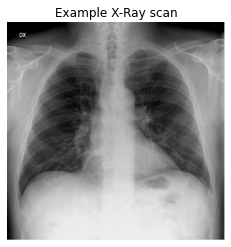

Example scan label:	  COVID
One-hot encoded label:  [1. 0.]


In [8]:
# Initialize the variables for training
dataset_path = f'{path}/dataset'
init_lr = 1e-3
epochs = 100
batch_size = 5


# Read all files from path
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels_ = []

# loop over the image paths
for imagePath in imagePaths:
    print(imagePath)
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    print(label)
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    image = cv2.resize(image, (512, 512))

    # update the data and labels lists, respectively
    data.append(image)
    labels_.append(label)

# Normalize images to range [0,1]
data = np.array(data) / 255.0
labels_ = np.array(labels_)

# Plot example patient scan
print('Number of training images: ', len(data))
print()
show_image(data[0])

# perform one-hot encoding on the labels
print('Example scan label:\t ', labels_[0])
lb = LabelBinarizer()
labels = lb.fit_transform(labels_)
labels = to_categorical(labels)
print('One-hot encoded label: ', labels[0])

In [16]:
# split training and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=3, shuffle=True)

(trainX, validX, trainY, validY) = train_test_split(trainX, trainY,
	test_size=0.20, stratify=trainY, random_state=3, shuffle=True)

print('Number of training pairs: ', len(trainX))
print('Number of validation pairs: ', len(validX))
print('Number of testing pairs: ', len(testX))

# # initialize the training data augmentation object
trainAug = ImageDataGenerator(
	# rescale=1 / 255.0,
	rotation_range=10,
	# zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	# horizontal_flip=True,
	# vertical_flip=True,
	fill_mode="nearest")

# Load the VGG16 network
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(512, 512, 3)))

# Make all pre-trained layers from VGG19 non-trainable 
for layer in baseModel.layers[:-3]:
    layer.trainable = False

# Add trainable fully-connected (FC) layers for predictions
newModel = baseModel.output
newModel = AveragePooling2D(pool_size=(4, 4))(newModel)
newModel = Flatten(name="flatten")(newModel)
newModel = Dense(64, activation="relu")(newModel)
newModel = Dropout(0.5)(newModel)
newModel = Dense(2, activation="softmax")(newModel)

# Stack the FC layers on top of VGG19 model
model = Model(inputs=baseModel.input, outputs=newModel, name='Covid19_Detector')

# compile our model
print("\n[INFO] compiling model...")
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Number of training pairs:  132
Number of validation pairs:  34
Number of testing pairs:  42

[INFO] compiling model...


In [36]:
idx = np.random.randint(0,len(data))
print('idx: ', idx)
print()
print(labels_[idx])
print(labels[idx])

idx:  82

normal
[0. 1.]


In [0]:
class_weights = {0 : 1, 1 : 2.01}

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

In [20]:
# train the model
print("[INFO] training new model ...")
results = model.fit_generator(
	trainAug.flow(trainX, trainY),
	# steps_per_epoch=len(trainX) // batch_size,
	validation_data=(validX, validY),
	# validation_steps=len(testX) // batch_size,
    callbacks = [early_stopping],
	epochs=epochs,
    # class_weight = class_weights
    )

[INFO] training new model ...
  ...
    to  
  ['...']
Train for 5 steps, validate on 34 samples
Epoch 1/100
5/5 [==============================] - 8s 2s/step - loss: 0.4789 - accuracy: 0.7576 - val_loss: 0.2310 - val_accuracy: 0.9118
Epoch 2/100
5/5 [==============================] - 7s 1s/step - loss: 0.3274 - accuracy: 0.9091 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.0765 - accuracy: 0.9697 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 4/100
5/5 [==============================] - 7s 1s/step - loss: 0.0824 - accuracy: 0.9773 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/100
5/5 [==============================] - 7s 1s/step - loss: 0.0505 - accuracy: 0.9924 - val_loss: 5.4363e-04 - val_accuracy: 1.0000
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.0497 - accuracy: 0.9773 - val_loss: 4.5449e-04 - val_accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 8s 2s/step - los

Analyse Results from the Test Set

In [21]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
print('\nNumber of test scans: ', len(testX))
print('Predicted class probabilities:')
print(predIdxs)

# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Covid=1, Normal=0):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)

[INFO] evaluating network...

Number of test scans:  42
Predicted class probabilities:
[[8.46906379e-03 9.91531014e-01]
 [8.84703457e-01 1.15296483e-01]
 [4.86311037e-04 9.99513745e-01]
 [8.22497070e-01 1.77502960e-01]
 [5.09054074e-03 9.94909465e-01]
 [1.59294825e-04 9.99840736e-01]
 [2.10860730e-04 9.99789178e-01]
 [1.54422992e-03 9.98455763e-01]
 [2.50029349e-04 9.99749959e-01]
 [5.04578114e-01 4.95421886e-01]
 [2.52716040e-04 9.99747336e-01]
 [9.06932116e-01 9.30678174e-02]
 [9.09708440e-01 9.02915671e-02]
 [2.62116606e-04 9.99737918e-01]
 [3.73089315e-05 9.99962687e-01]
 [9.04829204e-01 9.51707736e-02]
 [9.95652052e-04 9.99004424e-01]
 [7.57958274e-04 9.99242067e-01]
 [8.78775775e-01 1.21224262e-01]
 [8.39816039e-06 9.99991655e-01]
 [4.86437768e-01 5.13562262e-01]
 [7.09196092e-06 9.99992967e-01]
 [2.47696221e-01 7.52303720e-01]
 [4.61001834e-03 9.95389938e-01]
 [2.26557255e-04 9.99773443e-01]
 [2.89319130e-03 9.97106850e-01]
 [9.09796238e-01 9.02037397e-02]
 [2.28186382e-05 9.999

Loss/Accuracy Curve

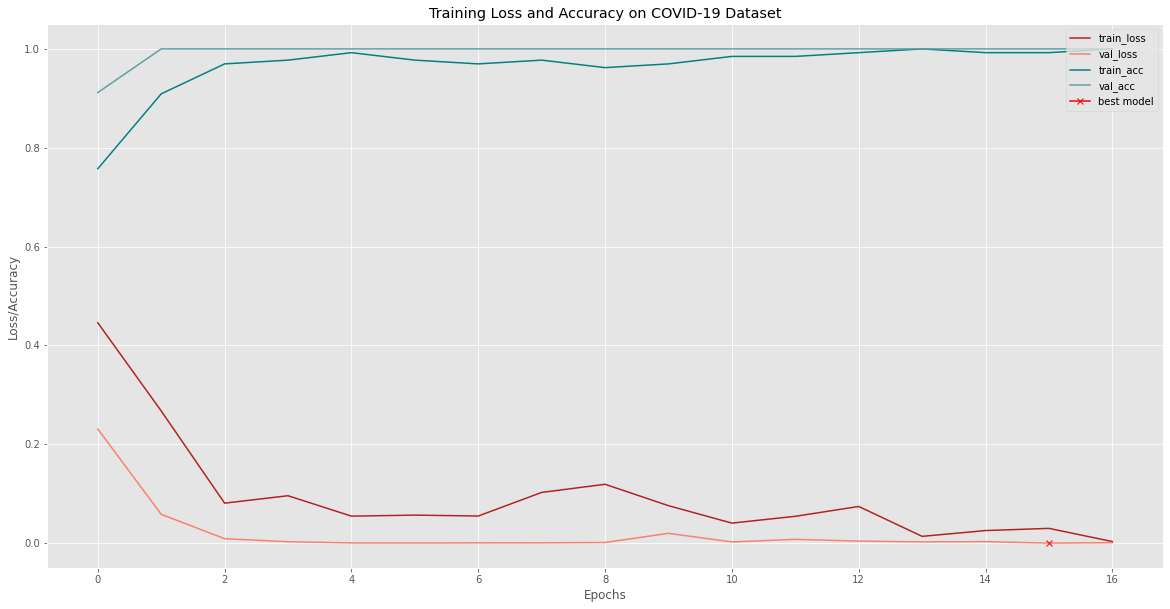

In [22]:
N = len(results.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), results.history["accuracy"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), results.history["val_accuracy"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('loss_curve.pdf', format='pdf')
plt.show()

compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity

loss :  0.09943014188181787
accuracy :  0.97619045

              precision    recall  f1-score   support

       COVID       1.00      0.93      0.96        14
      normal       0.97      1.00      0.98        28

    accuracy                           0.98        42
   macro avg       0.98      0.96      0.97        42
weighted avg       0.98      0.98      0.98        42

accuracy: 0.9762
sensitivity: 0.9286
specificity: 1.0000

Correct Healthy Patient Detection (True Negatives):  13
Incorrect Covid-19 Detection (False Positives):  1
Incorrect Healthy Patient Detection (False Negatives):  0
Correct Covid-19 Detection (True Positives):  28
Total Patietns with Covid-19:  28



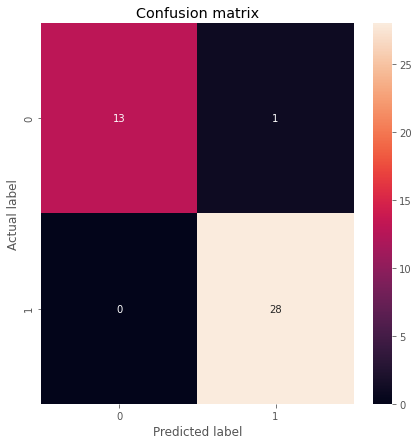

In [23]:
predicted_metrics = model.evaluate(testX, testY,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

plot_cm(trueIdxs, predIdxs)
plt.savefig('confusion_matrix.pdf', format='pdf')

Experiments with a second custom network


In [0]:
class CovidNet:
	@staticmethod
	def build(width, height, depth, classes):
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
            # CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# (CONV => RELU => POOL) * 2
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# (CONV => RELU => POOL) * 3
		model.add(SeparableConv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
  
        # first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(256))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

Account for unbalanced classes/skewness

In [53]:
# account for skew in the labeled data
trainLabels = to_categorical(trainX)
classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max() / classTotals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
model1 = CovidNet.build(width=512, height=512, depth=3,
	classes=2)
opt = Adagrad(lr=init_lr, decay=init_lr / epochs)
model1.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [26]:
# fit the model
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch_size),
	# steps_per_epoch=totalTrain // batch_size,
	validation_data=(validX, validY),
	# validation_steps=totalVal // batch_size,
	# class_weight=classWeight,
    callbacks = [early_stopping],
	epochs=epochs)

  ...
    to  
  ['...']
Train for 27 steps, validate on 34 samples
Epoch 1/100
27/27 [==============================] - 8s 287ms/step - loss: 0.3725 - accuracy: 0.9167 - val_loss: 0.3292 - val_accuracy: 0.9118
Epoch 2/100
27/27 [==============================] - 7s 277ms/step - loss: 0.0982 - accuracy: 0.9545 - val_loss: 0.1278 - val_accuracy: 0.9412
Epoch 3/100
27/27 [==============================] - 8s 279ms/step - loss: 0.1784 - accuracy: 0.9848 - val_loss: 8.9058e-07 - val_accuracy: 1.0000
Epoch 4/100
27/27 [==============================] - 8s 279ms/step - loss: 0.2022 - accuracy: 0.9697 - val_loss: 1.8340e-04 - val_accuracy: 1.0000
Epoch 5/100
27/27 [==============================] - 8s 280ms/step - loss: 0.5123 - accuracy: 0.9242 - val_loss: 4.6995e-05 - val_accuracy: 1.0000
Epoch 6/100
27/27 [==============================] - 8s 286ms/step - loss: 0.1185 - accuracy: 0.9848 - val_loss: 0.6722 - val_accuracy: 0.9412
Epoch 7/100
27/27 [==============================] - 8s 289ms/

loss :  0.6931470164230892
accuracy :  0.33333334

              precision    recall  f1-score   support

       COVID       1.00      0.93      0.96        14
      normal       0.97      1.00      0.98        28

    accuracy                           0.98        42
   macro avg       0.98      0.96      0.97        42
weighted avg       0.98      0.98      0.98        42

accuracy: 0.9762
sensitivity: 0.9286
specificity: 1.0000

Correct Healthy Patient Detection (True Negatives):  13
Incorrect Covid-19 Detection (False Positives):  1
Incorrect Healthy Patient Detection (False Negatives):  0
Correct Covid-19 Detection (True Positives):  28
Total Patietns with Covid-19:  28



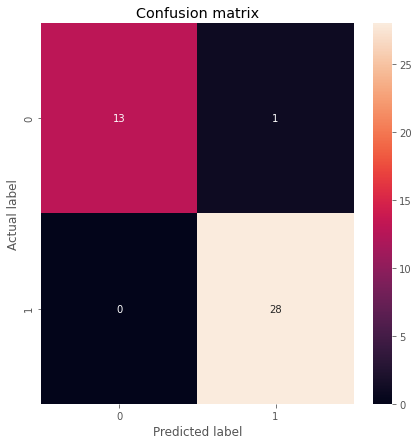

In [27]:
predicted_metrics = model1.evaluate(testX, testY,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model1.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

plot_cm(trueIdxs, predIdxs)